Hey there, hope you're having an amazing day. Welcome to this set of NLP tools and functions.

As it's usually the case in all data science projects, pre-processing is the most time-consuming step. Text data is of course no exception. During work in several NLP projects I found myself performing certain tasks repeatedly and noticed that I used much of my time doing the same actions over and over. To save myself sometime and make those processes easily repeatable I wrote the series of functions included in this notebook.

You will find brief explanations before every function, the kinds of input they receive, and the outputs they create.

All functions were written for Python 3 and require the libraries imported in the following cell.

In [10]:
#Libraries are imported

import pandas as pd

import json

import nltk

import statistics

import string

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from nltk.stem import WordNetLemmatizer

from nltk import word_tokenize

from nltk.util import ngrams

from gensim.models import Word2Vec, Phrases

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer

stop_words = list(set(nltk.corpus.stopwords.words('english')))

### dfToDict()

The first function, dfToDict() is a prerequisite for other functions down the line and also helps you quickly transform data from a Pandas dataframe into a dictionary. You can use this function if the use of dataframes is making your code slow and the procedure you are following can be adapted to a dictionary.

dfToDict has the following arguments:

df = Pandas dataframe

method = Either "rows", "columns" or "category_based". If rows or columns are chosen, row index and column names will be the keys of the output dictionary, if "category_based" is chosen, the values from another column in the dataframe will be taken as keys for the output dict

columns = A list. It allows you to only transform a subset of the dataframe by indicating the list of columns you want to transform

categories = A list. You can choose any two columns to represent either the keys or values of the output dictionary

In [2]:
def dfToDict(df, method, columns = [], categories = []):
    
    if method == "columns":
    
        if len(columns) == 0:

            columns = df.columns 

        columns_list = [list(df.loc[:, w]) for w in columns]

        output_dict = {key : value for (key, value) in zip(columns, columns_list)}
        
    if method == "rows":
    
        if len(columns) == 0:

            columns = df.columns
            
        df.reset_index(inplace = True, drop = True)
        
        keys = list(df.index)
        
        values_list = [{k : v for (k, v) in zip(columns, df.loc[x, columns])} for x in list(df.index)]

        output_dict = {key : value for (key, value) in zip(keys, values_list)}
        
    if method == "category_based":
        
        if len(categories) != 2:
            
            raise ValueError("Wrong number of categories selected. It must be two")
            
        key = categories[0]
        
        value = categories[1]
        
        key_list = list(set(list(df.loc[:, key])))
        
        output_dict = {k : v for (k, v) in zip(key_list, [list(df[df[key] == cat][value].values) for cat in key_list])}      

    return output_dict

### preProcDf()

The function preProcDf takes a pandas dataframe as input. You must specify the column containing text data and the function will return a list containing all documents in the original column after preprocessing. You can select which pre-processing steps to perform

preProcDf has the following arguments:

df = Pandas dataframe containing at least one column with text

corpus_col = A string, the name of the column you want to process

stop_words_list = a list of stop words you want to remove. You can use the following line of code to create a standard stop words list in English:

    stop_words = list(set(nltk.corpus.stopwords.words('english')))
    
remove_stop_words = True or false for removing stop words, it is True by default

remove_punctuation = True or false for removing punctuation, it is True by default

lemmatization = True or false for lemmatizing, it is False by default

join = If true the output includes every document as a single string, if false it returns a list of tokens per document

n = An integer, the number of n-grams for tokenization



In [3]:
def preProcDf(df, corpus_col, stop_words_list, remove_stop_words = True, lemmatization = False, remove_punctuation = True, join = True, n = 1):
    
    lemmatizer = WordNetLemmatizer()
    
    if remove_stop_words == True:
        
        if remove_punctuation == True:
            
            stop_words_list = stop_words_list + list(string.punctuation)
            
        else:
            
            stop_words_list = stop_words_list
            
    else:
        
        if remove_punctuation == True:
            
            stop_words_list = list(string.punctuation)
            
        else:
            
            stop_words_list = []
    
    list_to_process = list(df.loc[:, corpus_col])
    
    list_to_process = [str(w).lower() for w in list_to_process]
        
    if lemmatization == True:
        
        list_to_process = [["_".join([lemmatizer.lemmatize(t) for t in w]) for w in ngrams(word_tokenize(z), n) if not any(x in w for x in stop_words_list)] for z in list_to_process]
        
    else:
        
        list_to_process = [["_".join(w) for w in ngrams(word_tokenize(z), n) if not any(x in w for x in stop_words_list)] for z in list_to_process]
            
    if join == True:
        
        list_to_process = [" ".join(w) for w in list_to_process]
        
    return list_to_process

### preProcList()

The function preProcList is similar to preProcDf but takes a list as input. The result will be a list containing all documents in the original list after preprocessing. You can select which pre-processing steps to perform

preProcDf has the following arguments:

input_list = A list containing documents

stop_words_list = a list of stop words you want to remove. You can use the following line of code to create a standard stop words list in English:

    stop_words = list(set(nltk.corpus.stopwords.words('english')))
    
remove_stop_words = True or false for removing stop words, it is True by default

remove_punctuation = True or false for removing punctuation, it is True by default

lemmatization = True or false for lemmatizing, it is False by default

join = If true the output includes every document as a single string, if false it returns a list of tokens per document

n = An integer, the number of n-grams for tokenization

In [4]:
def preProcList(input_list, stop_words_list, remove_stop_words = True, lemmatization = False, remove_punctuation = True, join = True, n = 1):
    
    lemmatizer = WordNetLemmatizer()
    
    if remove_stop_words == True:
        
        if remove_punctuation == True:
            
            stop_words_list = stop_words_list + list(string.punctuation)
            
        else:
            
            stop_words_list = stop_words_list
            
    else:
        
        if remove_punctuation == True:
            
            stop_words_list = list(string.punctuation)
            
        else:
            
            stop_words_list = []
    
    list_to_process = input_list
    
    list_to_process = [str(w).lower() for w in list_to_process]
    
    if lemmatization == True:
        
        list_to_process = [["_".join([lemmatizer.lemmatize(t) for t in w]) for w in ngrams(word_tokenize(z), n) if not any(x in w for x in stop_words_list)] for z in list_to_process]
        
    else:
        
        list_to_process = [["_".join(w) for w in ngrams(word_tokenize(z), n) if not any(x in w for x in stop_words_list)] for z in list_to_process]
        
    if join == True:
        
        list_to_process = [" ".join(w) for w in list_to_process]
        
    return list_to_process

### getVocab()

getVocab() receives either a Pandas dataframe with at least one column containing documents, a dictionary with documents as values, or a list of documents. It returns a list of all unique tokens in the corpus. Needs dfToDict(), preProcDf(), and preProcList() to be created beforehand

getVocab() has the following arguments:

source = Either Pandas dataframe, dictionary, or list

method = either "all" or "category_based". "all" will return a single list of all unique tokens in the corpus. If "category_based" is chosen, the original corpus will be divided according to the values of another variable and a dictionary containing the vocabularies for each one of the levels of the variable used for filtering will be returned

stop_words_list = List containing stop words

corpus_col = A string. The name of the column to process if the input is a dataframe

filtering_var = A string with a column name. In case you need to create different vocabularies by filtering the corpus according to the values of another variable in the dataframe. The output will be a dictionary with each level of the variable used for filtering as key, and the vocabulary as a list of tokens

remove_stop_words = True or false for removing stop words, it is True by default

remove_punctuation = True or false for removing punctuation, it is True by default

lemmatization = True or false for lemmatizing, it is False by default

n = An integer, the number of n-grams for tokenization

In [5]:
def getVocab(source, method, stop_words_list, corpus_col = "", filtering_var = "", remove_stop_words = True, remove_punctuation = True, lemmatization = False, n = 1):
    
    if method not in ["all", "category_based"]:
        
        raise ValueError("Method not specified correctly. Must be 'all', or 'category_based'")
        
    if type(source) not in [pd.core.frame.DataFrame, list, dict]:
        
        raise ValueError("Only DataFrames, lists, and dicts can be used as input")
    
    if type(source) == pd.core.frame.DataFrame:
        
        if method == "all":
            
            if len(corpus_col) == 0:
                
                raise ValueError("1 and only 1 text column is accepted")
            
            input_list = list(source.loc[:, corpus_col])
            
        if method == "category_based":
            
            if len(corpus_col) == 0:
                
                raise ValueError("1 and only 1 text column is accepted")
                
            if len(filtering_var) == 0:
                
                raise ValueError("Filtering variable needed")
                
            input_list = dfToDict(source, method = "category_based", categories = [filtering_var, corpus_col])
            
    if type(source) == dict:
        
        if method == "all":
            
            input_list = [value for value in source.values()]
            
            input_list = [j for i in input_list for j in i]
            
        if method == "category_based":
            
            input_list = source
            
    if type(source) == list:
        
        input_list = source
        
        if method == "category_based":
            
            print("Warning: List object does not have categories")
        
    if type(input_list) == list:
        
        if lemmatization == True:
        
            input_list = preProcList(input_list, stop_words_list = stop_words_list, join = False, lemmatization = True, n = n)
            
        else:
            
            input_list = preProcList(input_list, stop_words_list = stop_words_list, lemmatization = False, join = False, n = n) 
            
        input_list = [j for i in input_list for j in i]
            
        output = list(set(input_list))
        
    if type(input_list) == dict:
        
        if lemmatization == True:
            
            input_list = {k : preProcList(v, stop_words_list = stop_words_list, lemmatization = True, join = False, n = n) for (k, v) in input_list.items()}
            
        else:
            
            input_list = {k : preProcList(v, stop_words_list = stop_words_list, lemmatization = False, join = False, n = n) for (k, v) in input_list.items()}
            
        input_list = {k : [j for i in v for j in i] for (k, v) in input_list.items()}
        
        output = {k : list(set(v)) for(k, v) in input_list.items()}
        
    return output  

### getVocabCounts()

Similar to getVocab() but returns a dataframe with the the list of all unique tokens in the corpus as a columns, each token's term frequency as another column. If a filter is used, the levels of the variable used for filtering will be returned as another column in the output dataframe. Needs dfToDict(), preProcDf(), and preProcList() to be created beforehand

getVocab() has the following arguments:

source = Either Pandas dataframe, dictionary, or list

method = either "all" or "category_based". "all" will return a single list of all unique tokens in the corpus. If "category_based" is chosen, the original corpus will be divided according to the values of another variable and a dictionary containing the vocabularies for each one of the levels of the variable used for filtering will be returned

stop_words_list = List containing stop words

corpus_col = A string. The name of the column to process if the input is a dataframe

filtering_var = A string with a column name. In case you need to create different vocabularies by filtering the corpus according to the values of another variable in the dataframe. The output will be a dictionary with each level of the variable used for filtering as key, and the vocabulary as a list of tokens

remove_stop_words = True or false for removing stop words, it is True by default

remove_punctuation = True or false for removing punctuation, it is True by default

lemmatization = True or false for lemmatizing, it is False by default

n = An integer, the number of n-grams for tokenization

In [6]:
def getVocabCounts(source, method, stop_words_list, corpus_col = "", filtering_var = "", remove_stop_words = True, remove_punctuation = True, lemmatization = False, n = 1):
    
    if method not in ["all", "category_based"]:
        
        raise ValueError("Method not specified correctly. Must be 'all', or 'category_based'")
        
    if type(source) not in [pd.core.frame.DataFrame, list, dict]:
        
        raise ValueError("Only DataFrames, lists, and dicts can be used as input")
    
    if type(source) == pd.core.frame.DataFrame:
        
        if method == "all":
            
            if len(corpus_col) == 0:
                
                raise ValueError("1 and only 1 text column is accepted")
            
            input_list = list(source.loc[:, corpus_col])
            
        if method == "category_based":
            
            if len(corpus_col) == 0:
                
                raise ValueError("1 and only 1 text column is accepted")
                
            if len(filtering_var) == 0:
                
                raise ValueError("Filtering variable needed")
                
            input_list = dfToDict(source, method = "category_based", categories = [filtering_var, corpus_col])
            
    if type(source) == dict:
        
        if method == "all":
            
            input_list = [value for value in source.values()]
            
            input_list = [j for i in input_list for j in i]
            
        if method == "category_based":
            
            input_list = source
            
    if type(source) == list:
        
        input_list = source
        
        if method == "category_based":
            
            print("Warning: List object does not have categories")
        
    if type(input_list) == list:
        
        if lemmatization == True:
        
            input_list = preProcList(input_list, stop_words_list = stop_words_list, join = False, lemmatization = True, n = n)
            
        else:
            
            input_list = preProcList(input_list, stop_words_list = stop_words_list, join = False, lemmatization = False, n = n) 
            
        input_list = [j for i in input_list for j in i]
            
        set_list = list(set(input_list))
        
        counts_vector = [input_list.count(w) for w in set_list]
        
        output = pd.DataFrame({"token" : set_list, "n" : counts_vector})
        
        output.sort_values(by = "n", inplace = True, ascending = False)
        
        output.reset_index(inplace = True, drop = True)
        
    if type(input_list) == dict:
        
        if lemmatization == True:
            
            input_list = {k : preProcList(v, stop_words_list = stop_words_list, join = False, lemmatization = True, n = n) for (k, v) in input_list.items()}
            
        else:
            
            input_list = {k : preProcList(v, stop_words_list = stop_words_list, join = False, lemmatization = False, n = n) for (k, v) in input_list.items()}
            
        input_dict = {k : [j for i in v for j in i] for (k, v) in input_list.items()}
        
        set_dict = {k : list(set(v)) for(k, v) in input_dict.items()}
        
        output = pd.DataFrame()
        
        for key, value in input_dict.items():
            
            term_vector = set_dict[key]
            
            counts_vector = [value.count(w) for w in term_vector]
            
            append_df = pd.DataFrame({"token" : term_vector, "n" : counts_vector, "category" : key})
            
            append_df.sort_values(by = "n", inplace = True, ascending = False)
            
            output = output.append(append_df)            
        
    return output

### tfIdfinator()

Takes in a dataframe with a text column. It returns a dataframe with each unique token as columns and the tf_idf values for each token as rows. Needs preProcDf() to be created beforehand

tfIdfinator() uses the following arguments:

corpus = a dataframe

stop_words_list = List containing stop words

corpus_col = A string. The name of the column to process if the input is a dataframe

n = An integer, the number of n-grams for tokenization



In [7]:
def tfIdfinator(corpus, stop_words_list, corpus_col, n = 1):
    
    corpus = preProcDf(df = corpus, corpus_col = corpus_col, stop_words_list = stop_words_list, remove_stop_words = True, lemmatization = False, remove_punctuation = True, join = True, n = n)
    
    vectorizer = TfidfVectorizer()
    
    vectors = vectorizer.fit_transform(corpus)
    
    feature_names = vectorizer.get_feature_names()

    dense = vectors.todense()

    output = pd.DataFrame(dense, columns=feature_names)
    
    return output

### tokenCountinator()

Takes in a dataframe with a text column. It returns a dataframe with all unique tokens in a column and their respective frequency counts as a second column. Needs preProcDf() to be created beforehand

tokenCountinator() uses the following arguments:

corpus = a dataframe

stop_words_list = List containing stop words

corpus_col = A string. The name of the column to process if the input is a dataframe

n = An integer, the number of n-grams for tokenization

In [8]:
def tokenCountinator(corpus, stop_words_list, corpus_col, n = 1):
    
    corpus = preProcDf(df = corpus, stop_words_list = stop_words_list, corpus_col = corpus_col, remove_stop_words = True, lemmatization = False, remove_punctuation = True, join = True, n = n)
    
    vectorizer = CountVectorizer()
    
    vectors = vectorizer.fit_transform(corpus)
    
    feature_names = vectorizer.get_feature_names()

    dense = vectors.todense()

    output = pd.DataFrame(dense, columns=feature_names)
    
    return output

### nlpDescriptiveReport()

Takes in a Pandas dataframe with at least one column containing documents. It returns a dataframe with tf-idf for every document and token and a dataframe with counts for every token. If the method "category_based" is used, it prints out visualizations for the tokens with the highest frequency, highest tf-idf throughout the corpus, and lists of tokens that are exclusive to each of the levels of the filtering variable, as well as those that are shared. If the method "all" is used there are no comparisons.

nlpDescriptiveReport() has the following arguments:

corpus = The input dataframe

corpus_col = A string. The name of the column to process if the input is a dataframe

method = Either "all" or "category_based". If "all" is selected, no additional variables are used for filtering and the visualizations are produced for the entire corpus. If "category_based" is selected an additional categorical variable is used for filtering and visualizations are produced for each level of that variable.

n = An integer, the number of n-grams for tokenization

stop_words_list = List containing stop words

filtering_var = A string with the name of the categorical variable to be used for filtering if the "category_based" method is used





In [12]:
def nlpDescriptiveReport(corpus, corpus_col, method, n, stop_words_list, filtering_var = None):
    
    if method == "category_based":
        
        if filtering_var == None:
            
            raise Exception("Please indicate a category through the filtering_var argument")

        tfidf_df_1 = pd.concat([tfIdfinator(corpus = corpus, 
                                            stop_words_list = stop_words_list,
                                            corpus_col = corpus_col, n = n), 
                                corpus.loc[:, filtering_var]], axis = 1)

        counts_df_1 = getVocabCounts(corpus, method = "category_based", 
                                     corpus_col = corpus_col,
                                     stop_words_list = stop_words_list,
                                     filtering_var = filtering_var, 
                                     lemmatization = False,
                                     n = n)

        gen_vocab = getVocab(corpus, method = "all",
                             stop_words_list = stop_words_list,
                             corpus_col = corpus_col, n = n)

        vocab_dict = getVocab(corpus, method = "category_based", 
                              corpus_col = corpus_col,
                              stop_words_list = stop_words_list,
                              filtering_var = filtering_var, n = n)

        print("*" * 80 + "\n")

        print("NLP DESCRIPTIVE REPORT")

        print("\n" + "*" * 80)

        print("=" * 80 + "\n")

        print("This report is based on the following sample")

        for category in set(list(corpus.loc[:, filtering_var])):

            print(f"{len(corpus.loc[corpus[filtering_var] == category, :])} paragraphs for category {category}") 

        print("\n" + "=" * 80)

        print("=" * 80 + "\n")

        print("Most frequent tokens by category" + "\n")

        for category in set(list(counts_df_1.loc[:, "category"])):

            df = counts_df_1.loc[counts_df_1.category == category, :]
            
            try:

                with sns.axes_style("darkgrid"):
                    sns.barplot(x = df["n"][0:10], y = df["token"][0:10]).set_title(category.upper())

                plt.show()
                
            except:
                
                print("-" * 40 + "\n")
                
                print(f"Not enough n-grams for {category}")
                
                print("\n" + "-" * 40)

        print("\n" + "=" * 80 )

        print("=" * 80 + "\n")

        print("Most specific tokens by category" + "\n")

        for category in set(list(tfidf_df_1.iloc[:, -1])):

            df = tfidf_df_1

            df.columns = [*df.columns[:-1], "category_considered"]

            df = df.loc[df.category_considered == category, :]

            word_list = list(df.columns.values)

            word_list.remove("category_considered")

            avg_tf_list = []

            for word in word_list:

                avg_tf_list.append(np.mean(df[word]))

            tf_df = pd.DataFrame({"token" : word_list,
                                  "mean_tfidf" : avg_tf_list})

            tf_df = tf_df.loc[tf_df.mean_tfidf != 0, :]

            tf_df.sort_values(by = "mean_tfidf", inplace = True, ascending = False)

            tf_df = tf_df.iloc[0:10, :]
            
            try:

                with sns.axes_style("darkgrid"):
                    sns.barplot(x = tf_df["mean_tfidf"], y = tf_df["token"]).set_title(category.upper())

                plt.show()
                
            except:
                
                print("-" * 40 + "\n")
                
                print(f"Not enough n-grams for {category}")
                
                print("\n" + "-" * 40)

        print("\n" + "=" * 80 )

        unique_dict = {}

        for category in vocab_dict.keys():

            current_list = list(vocab_dict.keys())

            current_list = [w for w in current_list if w != category]

            list_of_interest = vocab_dict[category]

            list_of_comparison = []

            for comparison_cat in current_list:

                list_of_comparison = list_of_comparison + vocab_dict[comparison_cat]

            result_list = [w for w in list_of_interest if w not in list_of_comparison]

            unique_dict[category] = result_list

        shared_dict = {}

        for category in vocab_dict.keys():

            current_list = list(vocab_dict.keys())

            current_list = [w for w in current_list if w != category]

            list_of_interest = vocab_dict[category]

            list_of_comparison = []

            for comparison_cat in current_list:

                list_of_comparison = list_of_comparison + vocab_dict[comparison_cat]

            result_list = [w for w in list_of_interest if w in list_of_comparison]

            shared_dict[category] = result_list

        print("=" * 80 + "\n")

        print("Most popular unique tokens by category" + "\n")

        for category in set(list(counts_df_1.loc[:, "category"])):

            print("-" * 40 + "\n" + category.upper() + "\n" + "-" * 40)

            df = counts_df_1.loc[counts_df_1.category == category, :]

            df = counts_df_1.loc[counts_df_1.token.isin(unique_dict[category]), :]

            display(df[0:10])

        print("\n" + "=" * 80 )

        print("=" * 80 + "\n")

        print("Most popular shared tokens by category" + "\n")

        for category in set(list(counts_df_1.loc[:, "category"])):

            print("-" * 40 + "\n" + category.upper() + "\n" + "-" * 40)

            df = counts_df_1.loc[counts_df_1.category == category, :]

            df = counts_df_1.loc[counts_df_1.token.isin(shared_dict[category]), :]

            display(df[0:10])

        print("\n" + "=" * 80 )

        print("=" * 80 + "\n")

        print("Lexical diversity by category" + "\n")

        for category in vocab_dict.keys():

            print(f"Category {category} has {len(vocab_dict[category])} tokens in its vocabulary")

        print("\n" + "=" * 80 )
        
    elif method == "all":
        
        tfidf_df_1 = tfIdfinator(corpus = corpus, stop_words_list = stop_words_list, corpus_col = corpus_col, n = n)

        counts_df_1 = getVocabCounts(corpus, method = "all", 
                                     corpus_col = corpus_col,
                                     stop_words_list = stop_words_list,
                                     lemmatization = False,
                                     n = n)

        gen_vocab = getVocab(corpus, method = "all",
                             stop_words_list = stop_words_list,
                             corpus_col = corpus_col, n = n)

        vocab_dict = getVocab(corpus, method = "all",
                              stop_words_list = stop_words_list,
                              corpus_col = corpus_col,
                              n = n)

        print("*" * 80 + "\n")

        print("NLP DESCRIPTIVE REPORT")

        print("\n" + "*" * 80)

        print("=" * 80 + "\n")

        print("This report is based on the following sample")

        print(f"{len(corpus)} paragraphs in total")        
        
        print("\n" + "=" * 80)

        print("=" * 80 + "\n")

        print("Most frequent tokens" + "\n")
            
        try:

            with sns.axes_style("darkgrid"):
                sns.barplot(x = counts_df_1["n"][0:10], y = counts_df_1["token"][0:10]).set_title("TOKEN FREQUENCY")

            plt.show()
                
        except:
                
            print("-" * 40 + "\n")
                
            print(f"Not enough n-grams for a plot")
                
            print("\n" + "-" * 40)

        print("\n" + "=" * 80 )

        print("=" * 80 + "\n")

        print("Most specific tokens" + "\n")

        word_list = list(tfidf_df_1.columns.values)

        avg_tf_list = []

        for word in word_list:

            avg_tf_list.append(np.mean(tfidf_df_1[word]))

        tf_df = pd.DataFrame({"token" : word_list, 
                              "mean_tfidf" : avg_tf_list})

        tf_df = tf_df.loc[tf_df.mean_tfidf != 0, :]

        tf_df.sort_values(by = "mean_tfidf", inplace = True, ascending = False)

        tf_df = tf_df.iloc[0:10, :]
            
        try:

            with sns.axes_style("darkgrid"):
                sns.barplot(x = tf_df["mean_tfidf"], y = tf_df["token"]).set_title("SPECIFIC TOKENS")

            plt.show()
                
        except:
                
            print("-" * 40 + "\n")
                
            print(f"Not enough n-grams for plot")
                
            print("\n" + "-" * 40)

        print("\n" + "=" * 80 )

        print("=" * 80 + "\n")

        print("Lexical diversity" + "\n")

        print(f"The dataset has {len(vocab_dict)} tokens in its vocabulary")

        print("\n" + "=" * 80 )
        
    else:
        
        raise Exception("Method must be either all or category_based")
        
    return tfidf_df_1, counts_df_1

The following cell offers an example of nlpDescriptiveReport() using a dataframe with some tweets about Nintendo and Capcom

********************************************************************************

NLP DESCRIPTIVE REPORT

********************************************************************************

This report is based on the following sample
1000 paragraphs for category Capcom
1000 paragraphs for category Nintendo


Most frequent tokens by category



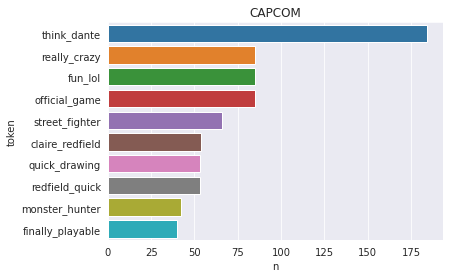

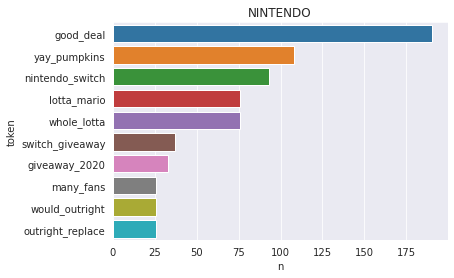



Most specific tokens by category



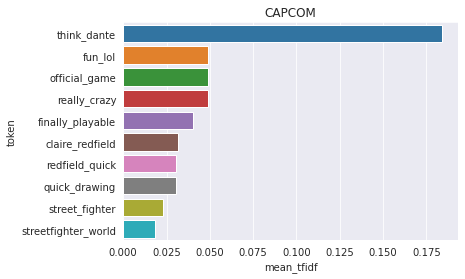

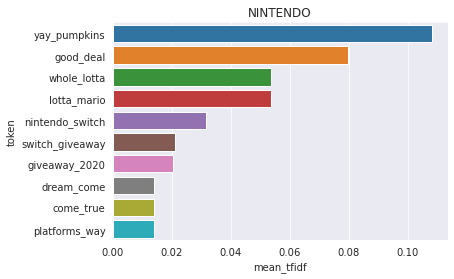



Most popular unique tokens by category

----------------------------------------
CAPCOM
----------------------------------------


,token,n,category
251,think_dante,184,Capcom
373,really_crazy,85,Capcom
836,fun_lol,85,Capcom
840,official_game,85,Capcom
165,street_fighter,66,Capcom
822,claire_redfield,54,Capcom
747,quick_drawing,53,Capcom
776,redfield_quick,53,Capcom
459,finally_playable,40,Capcom
167,streetfighter_world,37,Capcom


----------------------------------------
NINTENDO
----------------------------------------


,token,n,category
1075,good_deal,190,Nintendo
757,yay_pumpkins,108,Nintendo
663,lotta_mario,76,Nintendo
345,whole_lotta,76,Nintendo
139,switch_giveaway,37,Nintendo
355,giveaway_2020,33,Nintendo
689,many_fans,26,Nintendo
995,would_outright,26,Nintendo
996,outright_replace,26,Nintendo
162,replace_ness,26,Nintendo




Most popular shared tokens by category

----------------------------------------
CAPCOM
----------------------------------------


,token,n,category
110,monster_hunter,42,Capcom
796,hunter_themed,27,Capcom
864,themed_tarot,27,Capcom
144,black_dragon,26,Capcom
325,dragon_monster,26,Capcom
103,tarot_card,26,Capcom
222,mega_man,15,Capcom
877,megaman_x,8,Capcom
196,gameboy_color,6,Capcom
135,ca_n't,5,Capcom


----------------------------------------
NINTENDO
----------------------------------------


,token,n,category
110,monster_hunter,42,Capcom
796,hunter_themed,27,Capcom
864,themed_tarot,27,Capcom
144,black_dragon,26,Capcom
325,dragon_monster,26,Capcom
103,tarot_card,26,Capcom
222,mega_man,15,Capcom
877,megaman_x,8,Capcom
196,gameboy_color,6,Capcom
135,ca_n't,5,Capcom




Lexical diversity by category

Category Capcom has 891 tokens in its vocabulary
Category Nintendo has 1195 tokens in its vocabulary



In [33]:
corpus_df = pd.read_csv("gaming_tweets.csv", encoding = "latin1")

stop_words = stop_words + ["rt", "'s", "--", "https"]

gaming_tfidf, gaming_counts = nlpDescriptiveReport(corpus = corpus_df,
                                                   corpus_col = "text",
                                                   method = "category_based",
                                                   filtering_var = "company",
                                                   n = 2,
                                                   stop_words_list = stop_words)